<a href="https://colab.research.google.com/github/Byrnesz/point-of-interest-data/blob/master/Enrich_Your_Point_Of_Interest_Data_With_Census_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://global-uploads.webflow.com/5baafc2653bd67278f206724/5be267a03f7813daf821b31e_safegraph-logo-hidpi%403x-p-500.png)

# A Beginners Guide to Analyzing Census Data
#### A Starter Notebook for Open Census Data

--------------
**[Ryan Fox Squire](https://www.linkedin.com/in/ryanfoxsquire/) | Product Data Scientist, [SafeGraph](https://safegraph.com/?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=beginners_census_guide)**


Jan 2020

--------------
*Share this notebook: [Shareable Link](https://colab.research.google.com/drive/1JgU2MPUrITJBiEynZnFrZ8JyZAFYZY_1#offline=true&sandboxMode=true)*

This notebook is a simple demonstration of how to enrich point-of-interest data with census data using free and open-source data and software. 

## For more details see the accompanying blog: 
## [Everything you need to know to get started with Census and American Community Survey Data](https://www.safegraph.com/post/beginners-guide-to-census/?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=beginners_census_guide)

----
### Open Census Data
If you aren't familiar with Open Census Data, it is a free and easy CSV data download containing all of the Census and American Community Survey data. [Read here for more context on why we made Open Census Data](https://blog.safegraph.com/download-open-census-data-visualize-neighborhood-insights?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=beginners_census_guide). It sounds too good to be true, but pinch yourself, this is real. 


---
### Motivation

There are thousands of reasons you may want to bring census data into your workflow. Whether you are a retailer considering opening a store at a new location, an out-of-home advertiser considering investing in new billboards, or a researcher from the CDC trying to identify correlates of cancer diagnoses across a national patient population, all of these use cases (and many more) have one thing in common: you need to know demographic information about a point-of-interest. 

Here we show a working example of how to join demographic data from the Census and American Community Survey to your point-of-interet data. 


In [0]:
# special libraries to allow file access
from google.colab import drive as mountGoogleDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


## **How to use this notebook**:

---

**Quick Start:** 
1. You can run this notebook using some data I've prepared.  You only need to do one thing: Run the next cell, and follow the prompt to authenticate your google account.
2. **Everything else will just run! Enjoy!**


*p.s. FYI -- GeoPandas does not come installed in GoogleColab by default, so some of the cells below will install some libraries in your Google Colab session.*

In [0]:
# These commands allow you to read directly from SafeGraph's public GoogleDrive containing Census Data and Sample Data
auth.authenticate_user()  # Authenticate and create the PyDrive client. 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("You are fully authenticated and can edit and re-run everything in the notebook. Enjoy!")

You are fully authenticated and can edit and re-run everything in the notebook. Enjoy!


In [0]:
import pandas as pd

In [0]:
def pd_read_csv_drive(id, drive, dtype=None):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.csv')  
  return(pd.read_csv('Filename.csv',dtype=dtype))

def get_drive_id(filename):
    # Note: OpenCensusData public GDrive folder: https://drive.google.com/open?id=1btSS6zo7_wJCCXAigkbhnaoeU-Voa9pG
    # Note: Sample of SafeGraph Places data public GDrive folder: https://drive.google.com/open?id=1PRYLkWNlO-_5EXwFmUZbYbtr_UJmKjBq
    drive_ids = {'cbg.geojson' : '19FIPhdpDTw_hKZemRvqu2V6OiFn5KjQ1',
                 'cbg_b01.csv' : '1QqttoDRoKpZM2TyyRwJ8B9c5bYZrHysB',
                 'cbg_b19.csv' : '1d9GscpWbrnP2xNLKKlgd6xLcFTzJydY4', # You can look up the IDs for other cbg files here: https://drive.google.com/open?id=1btSS6zo7_wJCCXAigkbhnaoeU-Voa9pG 
                 'cbg_field_descriptions.csv' : '1a7_7WxY6eaUIObkVwfknl9C7nPltYxPd',
                 'sample_safegraph_places' : '1zgd13vjMlhiPDw1tsiR93lW3whBa-yOA' 
                 }
    return(drive_ids[filename])

## Step 1: Select Some Census Data

For this example, we will analyze `Median Household Income` (table_id `B19013e1`) and `Median Age` (table_id `B01002e1`)


Read more (LINK) for an orientation on the 7,500 possible variables you can choose from in Open Census Data and how to find them. 

You can [download Open Census Data here](https://www.safegraph.com/open-census-data?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=beginners_census_guide), and I've loaded some of it into a public google drive to power this demo. 


In [0]:
table_ids = ['B19013e1','B01002e1']
cbg_field_desc = pd_read_csv_drive(get_drive_id('cbg_field_descriptions.csv'), drive=drive)
cbg_field_desc[cbg_field_desc.table_id.isin(table_ids)]


,table_id,field_full_name,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8
126,B01002e1,MEDIAN AGE BY SEX: Total: Total population -- ...,Median Age By Sex,Total,Total Population -- (Estimate),NaN,NaN,NaN,NaN,NaN
3094,B19013e1,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,Median Household Income In The Past 12 Months ...,Total,Households -- (Estimate),NaN,NaN,NaN,NaN,NaN


In [0]:
cbg_data[['census_block_group'] + table_ids].head()

,census_block_group,B19013e1,B01002e1
0,010010201001,NaN,34.1
1,010010201002,77813.0,41.8
2,010010202001,25179.0,38.2
3,010010202002,45104.0,39.7
4,010010203001,55222.0,34.9


In [0]:
cbg_b19 = pd_read_csv_drive(get_drive_id('cbg_b19.csv'), drive=drive, dtype={'census_block_group': str})
cbg_b01 = pd_read_csv_drive(get_drive_id('cbg_b01.csv'), drive=drive, dtype={'census_block_group': str})
cbg_data = pd.merge(cbg_b01, cbg_b19, on=['census_block_group'])
cbg_data = cbg_data[['census_block_group'] + table_ids]
cbg_data.dropna().head()

,census_block_group,B19013e1,B01002e1
1,010010201002,77813.0,41.8
2,010010202001,25179.0,38.2
3,010010202002,45104.0,39.7
4,010010203001,55222.0,34.9
5,010010203002,27212.0,49.1


## Step 2: Add the census_block_group FIPs to your POI data

As an example, we can look at SafeGraph Places data for Home Depot. We want to know what is the Median Income and Median Age for the census block group in which each Home Depot is located. 

Our workflow is: 


1.   Load SafeGraph Places data
2.   Use GeoPandas to load the CBG Geometry GeoJSON from Open Census Data
3.   Use GeoPandas to do a geospatial join between the latitude/longitude centroid in SG Places and the polygon in the CBG Geometry file. 


For more explanation on how this geospatial join works, see [Join Point-Of-Interest Data To Census Data](https://colab.research.google.com/drive/1Kt3vPVIQJUq4QeJ-rE08URpIJEr1g2H3#offline=true&sandboxMode=true)) 


Step 2.1 Load SafeGraph Places data

In [0]:
places_df = pd_read_csv_drive(get_drive_id('sample_safegraph_places'), drive=drive)
print(places_df.shape)
places_df.head()

(1984, 38)


,safegraph_place_id,parent_safegraph_place_id,safegraph_brand_ids,location_name,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,open_hours,category_tags,polygon_wkt,polygon_class,phone_number,is_synthetic,includes_parking_lot,iso_country_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_work_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
0,sg:bfb88a1910434b169e5733a7015eb192,sg:d65e327ffc174e558b1c4450da1b47f2,SG_BRAND_8cebb51fb05f1bf005e53bfec08d6c10,The Home Depot,The Home Depot,Building Material and Supplies Dealers,Hardware Stores,444130,33.988801,-117.704133,14549 Ramona Ave,Chino,CA,91710,"{ ""Mon"": [[""6:00"", ""22:00""]], ""Tue"": [[""6:00"",...",NaN,POLYGON ((-117.7045127749443 33.98971909914596...,OWNED_POLYGON,1.909394e+10,False,NaN,US,1.575158e+09,1.577837e+09,2415.0,1554.0,"[108,83,59,66,90,101,136,114,104,79,77,76,89,9...","{""060710019031"":77,""060710001162"":42,""06071000...","{""060710005043"":33,""060710001152"":32,""06071000...","{""US"":1529}",5272.0,19.0,"{""<5"":53,""5-20"":1277,""21-60"":805,""61-240"":214,...","{""McDonald's"":10}","{""Starbucks"":44,""Target"":38,""Costco Wholesale ...","[4,4,4,4,3,14,46,96,157,241,295,333,351,357,35...","{""Monday"":382,""Tuesday"":301,""Wednesday"":201,""T...","{""android"":957,""ios"":597}"
1,sg:c5f302af4c5b4dfe9c88d4ac20b22f09,sg:cfe9f6e3a75c44d583c59b14817f6c32,SG_BRAND_8cebb51fb05f1bf005e53bfec08d6c10,The Home Depot,The Home Depot,Building Material and Supplies Dealers,Hardware Stores,444130,33.912652,-83.444808,1740 Epps Bridge Pkwy,Athens,GA,30606,"{ ""Mon"": [[""6:00"", ""22:00""]], ""Tue"": [[""6:00"",...",NaN,POLYGON ((-83.44516396522522 33.91324411319755...,OWNED_POLYGON,1.706354e+10,False,NaN,US,1.575158e+09,1.577837e+09,2549.0,1738.0,"[133,73,80,86,60,78,90,105,75,74,65,71,62,122,...","{""132190301002"":91,""132190303001"":59,""13219030...","{""132190301001"":33,""132190301002"":25,""13219030...","{""US"":1712}",18250.0,20.0,"{""<5"":50,""5-20"":1341,""21-60"":830,""61-240"":208,...","{""Lowe's"":14,""Tires Plus"":8,""Academy Sports + ...","{""Walmart"":50,""Chick-fil-A"":47,""Kroger"":41,""Lo...","[11,11,15,13,35,72,88,131,215,285,341,450,443,...","{""Monday"":383,""Tuesday"":358,""Wednesday"":216,""T...","{""android"":860,""ios"":879}"
2,sg:f7468238732b45d9bf7f662efdc342a0,NaN,SG_BRAND_8cebb51fb05f1bf005e53bfec08d6c10,The Home Depot,The Home Depot,Building Material and Supplies Dealers,Hardware Stores,444130,30.350485,-91.028705,18139 Highland Rd,Baton Rouge,LA,70810,"{ ""Mon"": [[""6:00"", ""22:00""]], ""Tue"": [[""6:00"",...",NaN,POLYGON ((-91.02857887744904 30.35129397140938...,OWNED_POLYGON,1.225755e+10,False,NaN,US,1.575158e+09,1.577837e+09,1919.0,1265.0,"[84,59,54,58,51,54,64,111,62,49,59,57,71,86,77...","{""220050302031"":102,""220330045101"":63,""2203300...","{""220330040092"":40,""220050303003"":20,""22005030...","{""US"":1235}",8702.0,19.0,"{""<5"":44,""5-20"":1069,""21-60"":592,""61-240"":132,...","{""Walmart"":7}","{""Walmart"":56,""Shell Oil"":36,""Walgreens"":33,""R...","[8,7,5,4,5,27,55,105,166,220,267,330,342,338,3...","{""Monday"":312,""Tuesday"":278,""Wednesday"":180,""T...","{""android"":516,""ios"":750}"
3,sg:19d8ab8d4ed34c5e89b1ec29371e1057,NaN,SG_BRAND_8cebb51fb05f1bf005e53bfec08d6c10,The Home Depot,The Home Depot,Building Material and Supplies Dealers,Hardware Stores,444130,39.058327,-76.960460,2300 Broadbirch Dr,Silver Spring,MD,20904,"{ ""Mon"": [[""6:00"", ""22:00""]], ""Tue"": [[""6:00"",...",NaN,"POLYGON ((-76.960631 39.05891, -76.960308 39.0...",OWNED_POLYGON,1.301680e+10,False,NaN,US,1.575158e+09,1.577837e+09,1879.0,1161.0,"[61,61,62,60,67,60,87,65,60,64,65,60,59,72,81,...","{""240317014181"":25,""240317014141"":21,""24031701...","{""240317014211"":14,""240317015061"":7,""240

Step 2.2 Use GeoPandas to load the CBG Geometry GeoJSON from Open Census Data

In [0]:
%%time 
# Install Geopandas (for spatial joins) onto Google CoLab
# HT: https://github.com/geopandas/geopandas/issues/901#issuecomment-458390318

# Install Gdal - rtree pre-req
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git

import geopandas as gpd

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-ld7re88r
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-ld7re88r
     |████████████████████████████████| 11.8MB 2.8MB/s 
     |████████████████████████████████| 10.1MB 24.7MB/s 
  Created wheel for geopandas: filename=geopandas-0.6.1+33.gadd5fe9-py2.py3-none-any.whl size=921332 sha256=b306cdff6a5b22fbc99c50599c2a5972cdb111f22b38bd3bebb95bf258ff0266
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4xiwqeo/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas
CPU times: user 270 ms, sys: 217 ms, total: 487 ms
Wall time: 12.2 s


Load all of the Census Block Group Geometries from Open Census Data. 

This is a large GeoJSON file so loading is a slow step (~ 4min 30 seconds)

In [0]:
%%time
# SLOW -- this is a large GeoJSON, so loading is a slow step. ~ 4min 30seconds
downloaded = drive.CreateFile({'id':get_drive_id('cbg.geojson')}) 
downloaded.GetContentFile('CBG_GEOS.csv')  
cbg_geos = gpd.read_file('CBG_GEOS.csv')
print(cbg_geos.shape)
print(cbg_geos.head())

(220333, 9)
  StateFIPS  ...                                           geometry
0        01  ...  MULTIPOLYGON (((-85.37282 32.63424, -85.37275 ...
1        01  ...  MULTIPOLYGON (((-85.38346 32.64838, -85.38301 ...
2        01  ...  MULTIPOLYGON (((-85.37139 32.60139, -85.37138 ...
3        01  ...  MULTIPOLYGON (((-86.64797 33.59205, -86.64771 ...
4        01  ...  MULTIPOLYGON (((-86.65206 33.59869, -86.65204 ...

[5 rows x 9 columns]
CPU times: user 4min 26s, sys: 15.3 s, total: 4min 42s
Wall time: 5min 32s


Step 2.3 Use GeoPandas to do a geospatial join between the latitude/longitude centroid in SG Places and the polygon in the CBG Geometry file.

In [0]:
%%time
places_gpd = places_df.copy()
print(places_gpd.shape)
places_gpd = places_gpd[places_gpd.iso_country_code=='US'][['safegraph_place_id', 'latitude', 'longitude']]
print(places_gpd.shape)
places_gpd = gpd.GeoDataFrame(places_gpd, geometry=gpd.points_from_xy(places_gpd.longitude, places_gpd.latitude))
places_gpd.crs = {'init' :'epsg:4326'} 
places_gpd = places_gpd[places_gpd.geometry.type == 'Point'][['safegraph_place_id', 'geometry']]
print(places_gpd.shape)

(1984, 38)
(1984, 3)
(1984, 2)
CPU times: user 33.8 ms, sys: 1.15 ms, total: 34.9 ms
Wall time: 48.3 ms


In [0]:
print(cbg_geos.shape)
cbgs = cbg_geos.rename(columns={'CensusBlockGroup':'census_block_group'})[['census_block_group', 'geometry']]
cbgs = cbgs[cbgs.geometry.type.isin(['Polygon', 'MultiPolygon'])]
print(cbgs.shape)
cbgs.head()

(220333, 9)
(220333, 2)


,census_block_group,geometry
0,010810416001,"MULTIPOLYGON (((-85.37282 32.63424, -85.37275 ..."
1,010810416002,"MULTIPOLYGON (((-85.38346 32.64838, -85.38301 ..."
2,010810417004,"MULTIPOLYGON (((-85.37139 32.60139, -85.37138 ..."
3,010730111074,"MULTIPOLYGON (((-86.64797 33.59205, -86.64771 ..."
4,010730111084,"MULTIPOLYGON (((-86.65206 33.59869, -86.65204 ..."


In [0]:
%%time
# SLOW STEP. Spatial Join.
poi_cbgs = gpd.sjoin(places_gpd, cbgs, how="left", op='intersects')
print(poi_cbgs.shape)
print(poi_cbgs[~poi_cbgs.census_block_group.isna()].shape)
print(poi_cbgs.head())

(1984, 4)
(1982, 4)
                    safegraph_place_id  ... census_block_group
0  sg:bfb88a1910434b169e5733a7015eb192  ...       060710005043
1  sg:c5f302af4c5b4dfe9c88d4ac20b22f09  ...       132190302001
2  sg:f7468238732b45d9bf7f662efdc342a0  ...       220330040091
3  sg:19d8ab8d4ed34c5e89b1ec29371e1057  ...       240317014211
4  sg:5c8e92835222419b801b2969493b3134  ...       170318316001

[5 rows x 4 columns]
CPU times: user 17.4 s, sys: 42.8 ms, total: 17.4 s
Wall time: 17.8 s


### Step 3. We're done. 

Now we have a map of `safegraph_place_id` to `census_block_group`, and can join the two datasets and do our analysis. 

For example, I can ask, "What is the distribution of `Median Age` and `Median Income` for `census_block_group`s containing a Home Depot? 

In [0]:
places_df_cbg = pd.merge(places_df, poi_cbgs, on=['safegraph_place_id'])
places_df_demos = pd.merge(places_df_cbg, cbg_data, on=['census_block_group'])


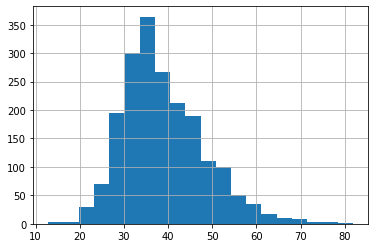

In [0]:
# Show me the distribution of Median Age for Census Block Groups containing a Home Depot
places_df_demos['B01002e1'].hist(bins=20)

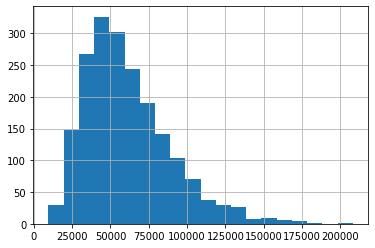

In [0]:
# Show me the distribution of Median Income for Census Block Groups containing a Home Depot
places_df_demos['B19013e1'].hist(bins=20)